In [1]:
from qiskit import *
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit import IBMQ
from qiskit.converters import circuit_to_dag
import json
from qiskit.tools.monitor import job_monitor
%matplotlib inline

### Sbox

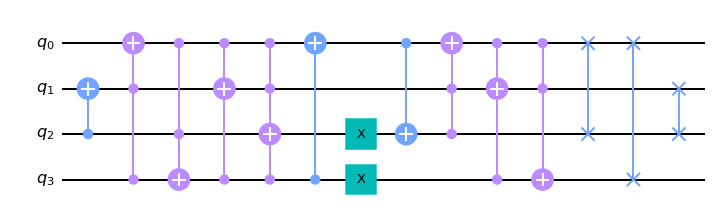

In [2]:
sbox = QuantumCircuit(4)
qubits = [
    [2,1],
    [3,1,0],
    [0,2,3],
    [0,3,1],
    [0,1,3,2],
    [3,0],
    [2],
    [3],
    [0,2],
    [1,2,0],
    [0,3,1],
    [0,1,3]
]

for i in qubits:
    if len(i) == 1:
        sbox.x(i[0])
    elif len(i) == 2:
        sbox.cnot(i[0],i[1])
    elif len(i) == 3:
        sbox.toffoli(i[0],i[1],i[2])
    else:
        sbox.mct(i[:-1],i[-1])

sbox.swap(0,2)
sbox.swap(0,3)
sbox.swap(1,2)

sbox.draw('mpl')

In [3]:
shots = 1000
simulator = Aer.get_backend('qasm_simulator')

for i in range(16):
    
    num = bin(i)[2:][::-1]
    qc = QuantumCircuit(4)
    
    for index, j in enumerate(num):
        if j == '1':
            qc.x(3 - index)
            
    qc = qc.compose(sbox,range(4))
    qc.measure_all()
    
    res = execute(qc,backend=simulator, shots=shots).result()
    counts = res.get_counts(qc)
    s = list(list(counts.keys())[0])
    
    out = int("".join(s[::-1]),2)
    print(i, out)
    
    del qc

0 9
1 4
2 10
3 11
4 13
5 1
6 8
7 5
8 6
9 2
10 0
11 3
12 12
13 14
14 15
15 7


In [4]:
sbox_gate = sbox.to_gate()
sbox_gate.name = 'SN'

### INV SBOX

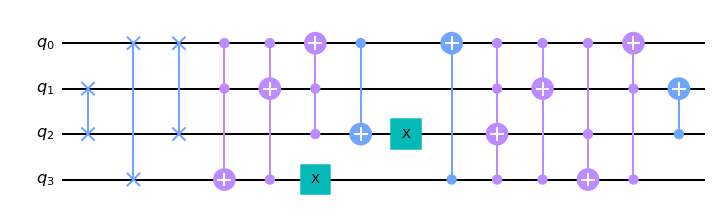

In [5]:
inv_sbox = QuantumCircuit(4)
qubits = [
    [2,1],
    [3,1,0],
    [0,2,3],
    [0,3,1],
    [0,1,3,2],
    [3,0],
    [2],
    [3],
    [0,2],
    [1,2,0],
    [0,3,1],
    [0,1,3]
]

inv_sbox.swap(1,2)
inv_sbox.swap(0,3)
inv_sbox.swap(0,2)

qubits = qubits[::-1]
for i in qubits:
    if len(i) == 1:
        inv_sbox.x(i[0])
    elif len(i) == 2:
        inv_sbox.cnot(i[0],i[1])
    elif len(i) == 3:
        inv_sbox.toffoli(i[0],i[1],i[2])
    else:
        inv_sbox.mct(i[:-1],i[-1])

inv_sbox.draw('mpl')

In [6]:
shots = 1000
simulator = Aer.get_backend('aer_simulator')

for i in range(16):
    
    num = bin(i)[2:][::-1]
    qc = QuantumCircuit(4)
    
    for index, j in enumerate(num):
        if j == '1':
            qc.x(3 - index)
            
    qc = qc.compose(inv_sbox,range(4))
    qc.measure_all()
    
    res = execute(qc,backend=simulator, shots=shots).result()
    counts = res.get_counts(qc)
    s = list(list(counts.keys())[0])
    
    out = int("".join(s[::-1]),2)
    print(i, out)
    
    del qc

0 10
1 5
2 9
3 11
4 1
5 7
6 8
7 15
8 6
9 0
10 2
11 3
12 12
13 4
14 13
15 14


In [7]:
inv_sbox_gate = inv_sbox.to_gate()
inv_sbox_gate.name = 'ISN'

### MC

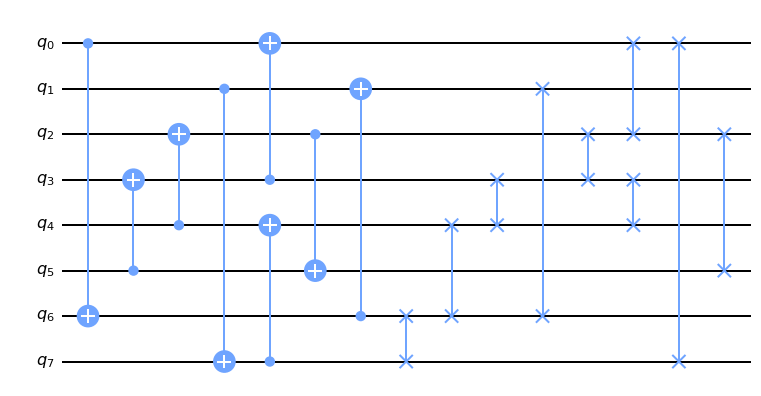

In [8]:
mc = QuantumCircuit(8)
qubits = [
    [0,6],
    [5,3],
    [4,2],
    [1,7],
    [7,4],
    [2,5],
    [3,0],
    [6,1]
]

for i in qubits:
    mc.cnot(i[0],i[1])

mc.swap(6,7)
mc.swap(6,4)
mc.swap(4,3)
mc.swap(3,2)
mc.swap(2,0)

mc.swap(0,7)
mc.swap(1,6)
mc.swap(2,5)
mc.swap(3,4)

mc.draw('mpl')

In [9]:
mix_col = np.array([[1, 4], [4, 1]])
def galoisMult(b, a):
    p = 0
    hiBitSet = 0
    for i in range(4):
        if b & 1 == 1:
            p ^= a
        a <<= 1
        hiBitSet = a & 0x10
        if hiBitSet:
            a ^= 0x13
        b >>= 1
    return p

def mix_column(state):
    res = np.zeros((2, 2)).astype(int)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                res[i][j] ^= galoisMult(mix_col[i][k],state[k][j])
    return res

In [10]:
state = np.zeros((2,2)).astype(int)
count = 0
test = [0]*8
for i in range(16):
    state[0][0] = i
    for j in range(16):
        state[1][0] = j
        mc_state = mix_column(state)
        
        actual = ((mc_state[0][0] << 12) | (mc_state[1][0] << 8) | (mc_state[0][1] << 4) | mc_state[1][1])
        
        qc = QuantumCircuit(8)
        
        num = ((state[0][0] << 12) | (state[1][0] << 8) | (state[0][1] << 4) | state[1][1])
        
        num = bin(num)[2:][::-1]

        for index,k in enumerate(num):
            if k == '1':
                qc.x(7-index)
            
        qc = qc.compose(mc, range(8))
        qc.measure_all()
        
        res = execute(qc,backend=simulator, shots=shots).result()
        counts = res.get_counts(qc) 
    
        out = list(counts.keys())[0][::-1] + '00000000'
        
        out = int(out, 2)
        
        if actual == out:
            count+=1
        del qc

if count == 16*16:
    print("Verified")

Verified


In [11]:
mc_gate = mc.to_gate()
mc_gate.name = 'MC'

### SR

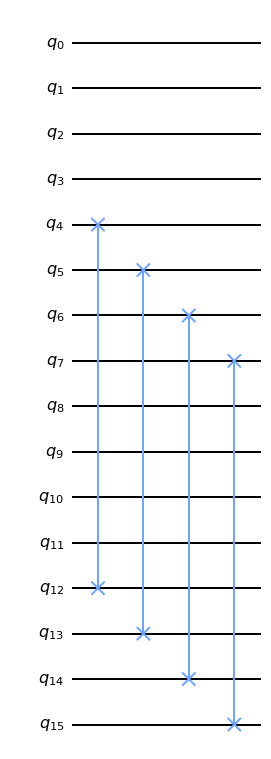

In [12]:
sr = QuantumCircuit(16)
qubits = [
    [4,12],
    [5,13],
    [6,14],
    [7,15],
]

for i in qubits:
    sr.swap(i[0],i[1])

sr.draw('mpl')

In [13]:
sr_gate = sr.to_gate()
sr_gate.name = 'SR'

### Add round key

In [14]:
ark = QuantumCircuit(32)
offset = 16
for i in range(16):
    ark.cnot(i, offset + i)
ark_gate = ark.to_gate()
ark_gate.name = 'AK'

### round1 key

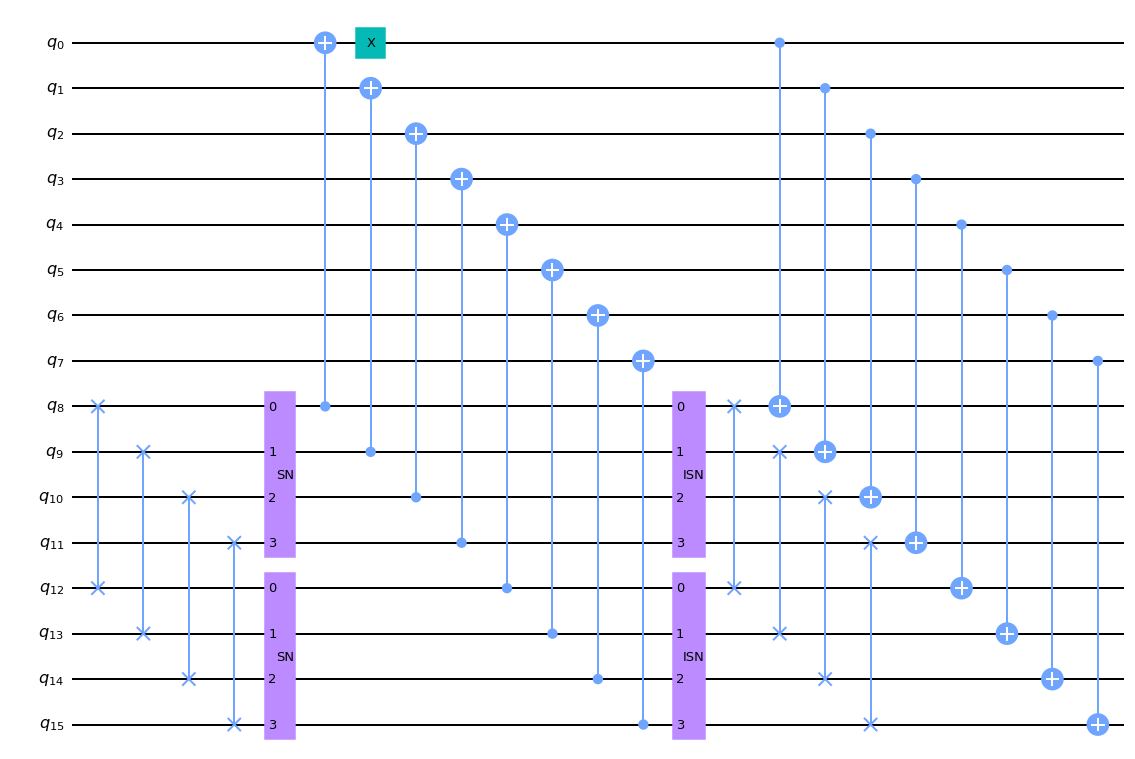

In [15]:
r1k = QuantumCircuit(16)
for i in range(4):
    r1k.swap(8 + i, 12 + i)

r1k.append(sbox_gate, range(8,12))
r1k.append(sbox_gate, range(12,16))

for i in range(8):
    r1k.cnot(8+i, i)

# rcon = 10000000
r1k.x(0)

# Reverse
r1k.append(inv_sbox_gate, range(8,12))
r1k.append(inv_sbox_gate, range(12,16))

for i in range(4):
    r1k.swap(8 + i, 12 + i)

for i in range(8):
    r1k.cnot(i, i+8)


r1k.draw('mpl')

In [16]:
r1k_gate = r1k.to_gate()
r1k_gate.name = 'R1K'

### round2 key

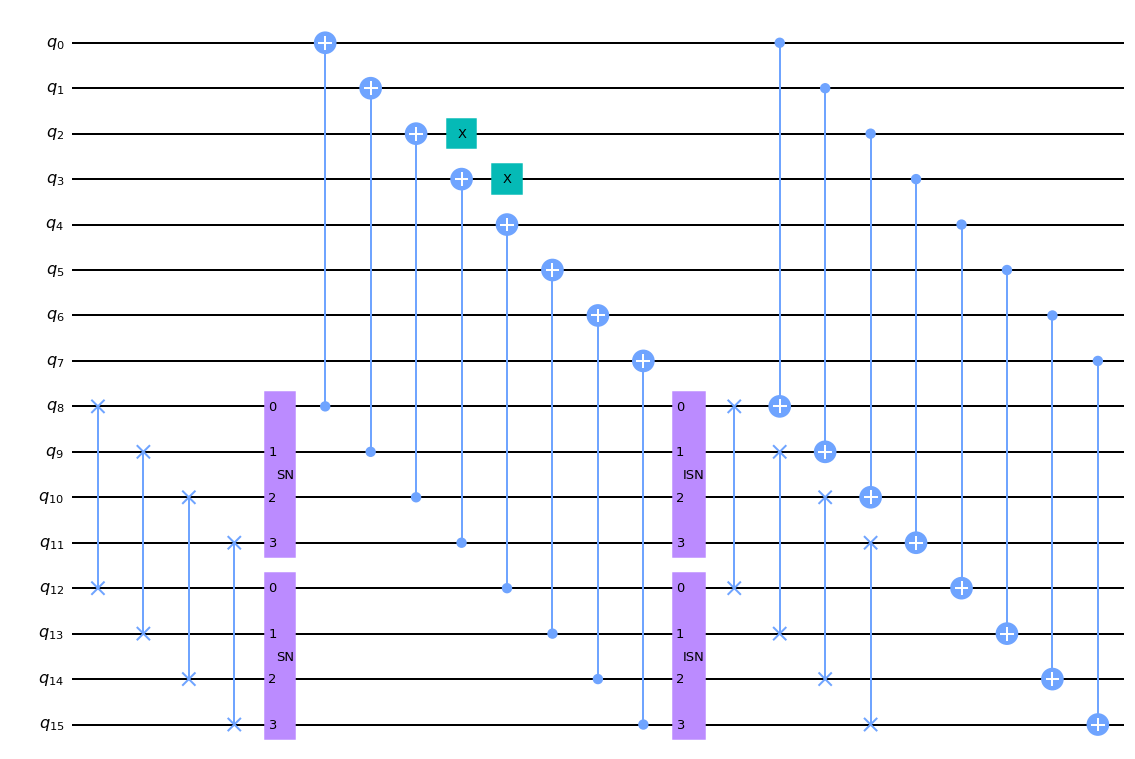

In [17]:
r2k = QuantumCircuit(16)
for i in range(4):
    r2k.swap(8 + i, 12 + i)

r2k.append(sbox_gate, range(8,12))
r2k.append(sbox_gate, range(12,16))

for i in range(8):
    r2k.cnot(8+i, i)

# rcon = 00110000
r2k.x(2)
r2k.x(3)

# Reverse
r2k.append(inv_sbox_gate, range(8,12))
r2k.append(inv_sbox_gate, range(12,16))

for i in range(4):
    r2k.swap(8 + i, 12 + i)

for i in range(8):
    r2k.cnot(i, i+8)


r2k.draw('mpl')

In [18]:
r2k_gate = r2k.to_gate()
r2k_gate.name = 'R2K'

### SAES21

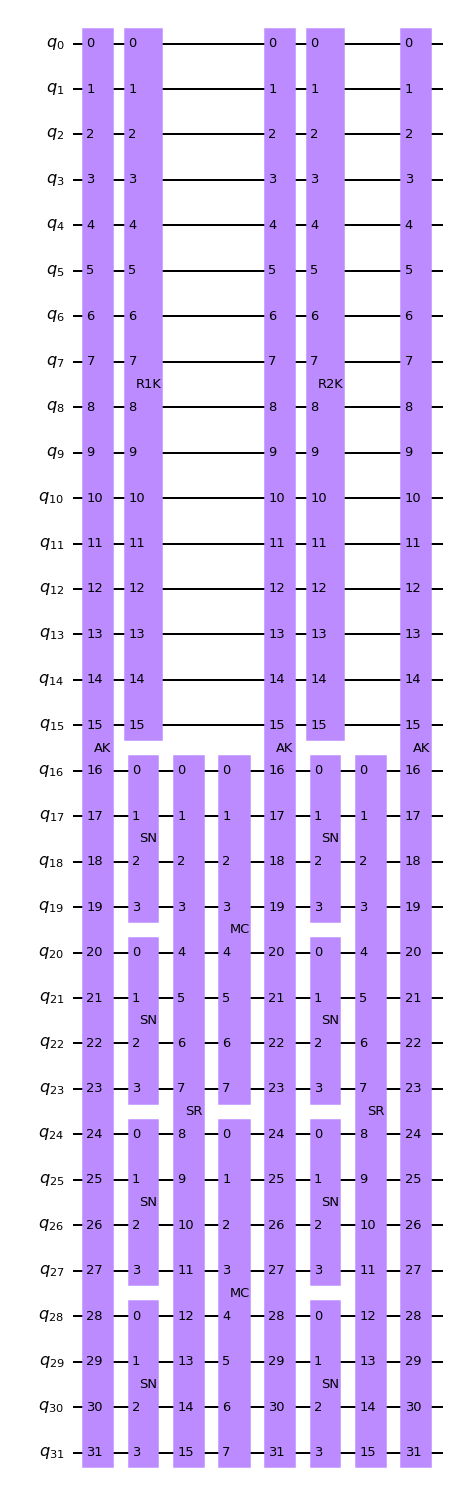

In [19]:
saes = QuantumCircuit(32)

# first 16 qubits for key
# later for plaintext

# xor key with plaintext
saes.append(ark_gate, range(32))

saes.append(sbox_gate, range(16,20))
saes.append(sbox_gate, range(20,24))
saes.append(sbox_gate, range(24,28))
saes.append(sbox_gate, range(28,32))

saes.append(sr_gate, range(16,32))

saes.append(mc_gate, range(16,24))
saes.append(mc_gate, range(24,32))

saes.append(r1k_gate,range(16))
saes.append(ark_gate, range(32))

saes.append(sbox_gate, range(16,20))
saes.append(sbox_gate, range(20,24))
saes.append(sbox_gate, range(24,28))
saes.append(sbox_gate, range(28,32))

saes.append(sr_gate, range(16,32))

saes.append(r2k_gate,range(16))
saes.append(ark_gate, range(32))   


saes.draw('mpl')

In [20]:
saes_gate = saes.to_gate()
saes_gate.name = "SAES"

In [56]:
saes_inv_gate = saes.inverse()

In [22]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [36]:
qcomp = provider.get_backend('ibmq_qasm_simulator')
saes_t_qc= transpile(saes, qcomp, optimization_level=2)

In [37]:
saes_t_qc.draw()

»
 q_0: ──■───────────────────────────────────────────────────────────────────»
        │                                                                   »
 q_1: ──┼────■──────────────────────────────────────────────────────────────»
        │    │                                                              »
 q_2: ──┼────┼────■─────────────────────────────────────────────────────────»
        │    │    │                                                         »
 q_3: ──┼────┼────┼────■────────────────────────────────────────────────────»
        │    │    │    │                                                    »
 q_4: ──┼────┼────┼────┼────■───────────────────────────────────────────────»
        │    │    │    │    │                                               »
 q_5: ──┼────┼────┼────┼────┼────■──────────────────────────────────────────»
        │    │    │    │    │    │                                          »
 q_6: ──┼────┼────┼────┼────┼────┼────■─────────────────────────────────────»
        │    │    │    │    │    │    │                                     »
 q_7: ──┼────┼────┼────┼────┼────┼────┼────■────────────────────────────────»
        │    │    │    │    │    │    │    │                                »
 q_8: ──┼────┼────┼────┼────┼────┼────┼────┼────■────────────────────────X──»
        │    │    │    │    │    │    │    │    │                        │  »
 q_9: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────■───────────────────┼──»
        │    │    │    │    │    │    │    │    │    │                   │  »
q_10: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■──────────────┼──»
        │    │    │    │    │    │    │    │    │    │    │              │  »
q_11: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■─────────┼──»
        │    │    │    │    │    │    │    │    │    │    │    │         │  »
q_12: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■────X──»
        │    │    │    │    │    │    │    │    │    │    │    │    │       »
q_13: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■──»
        │    │    │    │    │    │    │    │    │    │    │    │    │    │  »
q_14: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
        │    │    │    │    │    │    │    │    │    │    │    │    │    │  »
q_15: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
      ┌─┴─┐  │    │    │    │    │    │    │    │    │    │    │    │    │  »
q_16: ┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
      └───┘┌─┴─┐  │    │    │    │    │    │    │    │    │    │    │    │  »
q_17: ─────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
           └───┘┌─┴─┐  │    │    │    │    │    │    │    │    │    │    │  »
q_18: ──────────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
                └───┘┌─┴─┐  │    │    │    │    │    │    │    │    │    │  »
q_19: ───────────────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
                     └───┘┌─┴─┐  │    │    │    │    │    │    │    │    │  »
q_20: ────────────────────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼──»
                          └───┘┌─┴─┐  │    │    │    │    │    │    │    │  »
q_21: ─────────────────────────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼──»
                               └───┘┌─┴─┐  │    │    │    │    │    │    │  »
q_22: ──────────────────────────────┤ X ├──┼────┼────┼────┼────┼────┼────┼──»
                                    └───┘┌─┴─┐  │    │    │    │    │    │  »
q_23: ───────────────────────────────────┤ X ├──┼────┼────┼────┼────┼────┼──»
                                         └───┘┌─┴─┐  │    │    │    │    │  »
q_24: ────────────────────────────────────────┤ X ├──┼────┼────┼────┼────┼──»
                                              └───┘┌─┴─┐  │    │    │    │  »
q_25: ─────────────────────────────────────────────┤ X ├──┼────┼────┼────┼──»
                    

In [40]:
saes_t_qc.depth()

59

In [39]:
dict(saes_t_qc.count_ops())

{'cx': 144, 'ccx': 96, 'swap': 90, 'x': 35, 'mcx': 16}

In [57]:
qcomp = provider.get_backend('ibmq_qasm_simulator')
saes_inv_t_qc= transpile(saes, qcomp, optimization_level=2)

In [58]:
saes_inv_t_qc.draw()

»
 q_0: ──■───────────────────────────────────────────────────────────────────»
        │                                                                   »
 q_1: ──┼────■──────────────────────────────────────────────────────────────»
        │    │                                                              »
 q_2: ──┼────┼────■─────────────────────────────────────────────────────────»
        │    │    │                                                         »
 q_3: ──┼────┼────┼────■────────────────────────────────────────────────────»
        │    │    │    │                                                    »
 q_4: ──┼────┼────┼────┼────■───────────────────────────────────────────────»
        │    │    │    │    │                                               »
 q_5: ──┼────┼────┼────┼────┼────■──────────────────────────────────────────»
        │    │    │    │    │    │                                          »
 q_6: ──┼────┼────┼────┼────┼────┼────■─────────────────────────────────────»
        │    │    │    │    │    │    │                                     »
 q_7: ──┼────┼────┼────┼────┼────┼────┼────■────────────────────────────────»
        │    │    │    │    │    │    │    │                                »
 q_8: ──┼────┼────┼────┼────┼────┼────┼────┼────■────────────────────────X──»
        │    │    │    │    │    │    │    │    │                        │  »
 q_9: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────■───────────────────┼──»
        │    │    │    │    │    │    │    │    │    │                   │  »
q_10: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■──────────────┼──»
        │    │    │    │    │    │    │    │    │    │    │              │  »
q_11: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■─────────┼──»
        │    │    │    │    │    │    │    │    │    │    │    │         │  »
q_12: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■────X──»
        │    │    │    │    │    │    │    │    │    │    │    │    │       »
q_13: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■──»
        │    │    │    │    │    │    │    │    │    │    │    │    │    │  »
q_14: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
        │    │    │    │    │    │    │    │    │    │    │    │    │    │  »
q_15: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
      ┌─┴─┐  │    │    │    │    │    │    │    │    │    │    │    │    │  »
q_16: ┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
      └───┘┌─┴─┐  │    │    │    │    │    │    │    │    │    │    │    │  »
q_17: ─────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
           └───┘┌─┴─┐  │    │    │    │    │    │    │    │    │    │    │  »
q_18: ──────────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
                └───┘┌─┴─┐  │    │    │    │    │    │    │    │    │    │  »
q_19: ───────────────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
                     └───┘┌─┴─┐  │    │    │    │    │    │    │    │    │  »
q_20: ────────────────────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼──»
                          └───┘┌─┴─┐  │    │    │    │    │    │    │    │  »
q_21: ─────────────────────────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼──»
                               └───┘┌─┴─┐  │    │    │    │    │    │    │  »
q_22: ──────────────────────────────┤ X ├──┼────┼────┼────┼────┼────┼────┼──»
                                    └───┘┌─┴─┐  │    │    │    │    │    │  »
q_23: ───────────────────────────────────┤ X ├──┼────┼────┼────┼────┼────┼──»
                                         └───┘┌─┴─┐  │    │    │    │    │  »
q_24: ────────────────────────────────────────┤ X ├──┼────┼────┼────┼────┼──»
                                              └───┘┌─┴─┐  │    │    │    │  »
q_25: ─────────────────────────────────────────────┤ X ├──┼────┼────┼────┼──»
                    

In [59]:
saes_inv_t_qc.depth()

59

In [60]:
dict(saes_inv_t_qc.count_ops())

{'cx': 144, 'ccx': 96, 'swap': 90, 'x': 35, 'mcx': 16}

### Experiment 1: Verify Oracle for a key and plaintext

In [41]:
msg = '0110111101101011'
key = '1010011100111011'
#cipher = '0000011100111000'

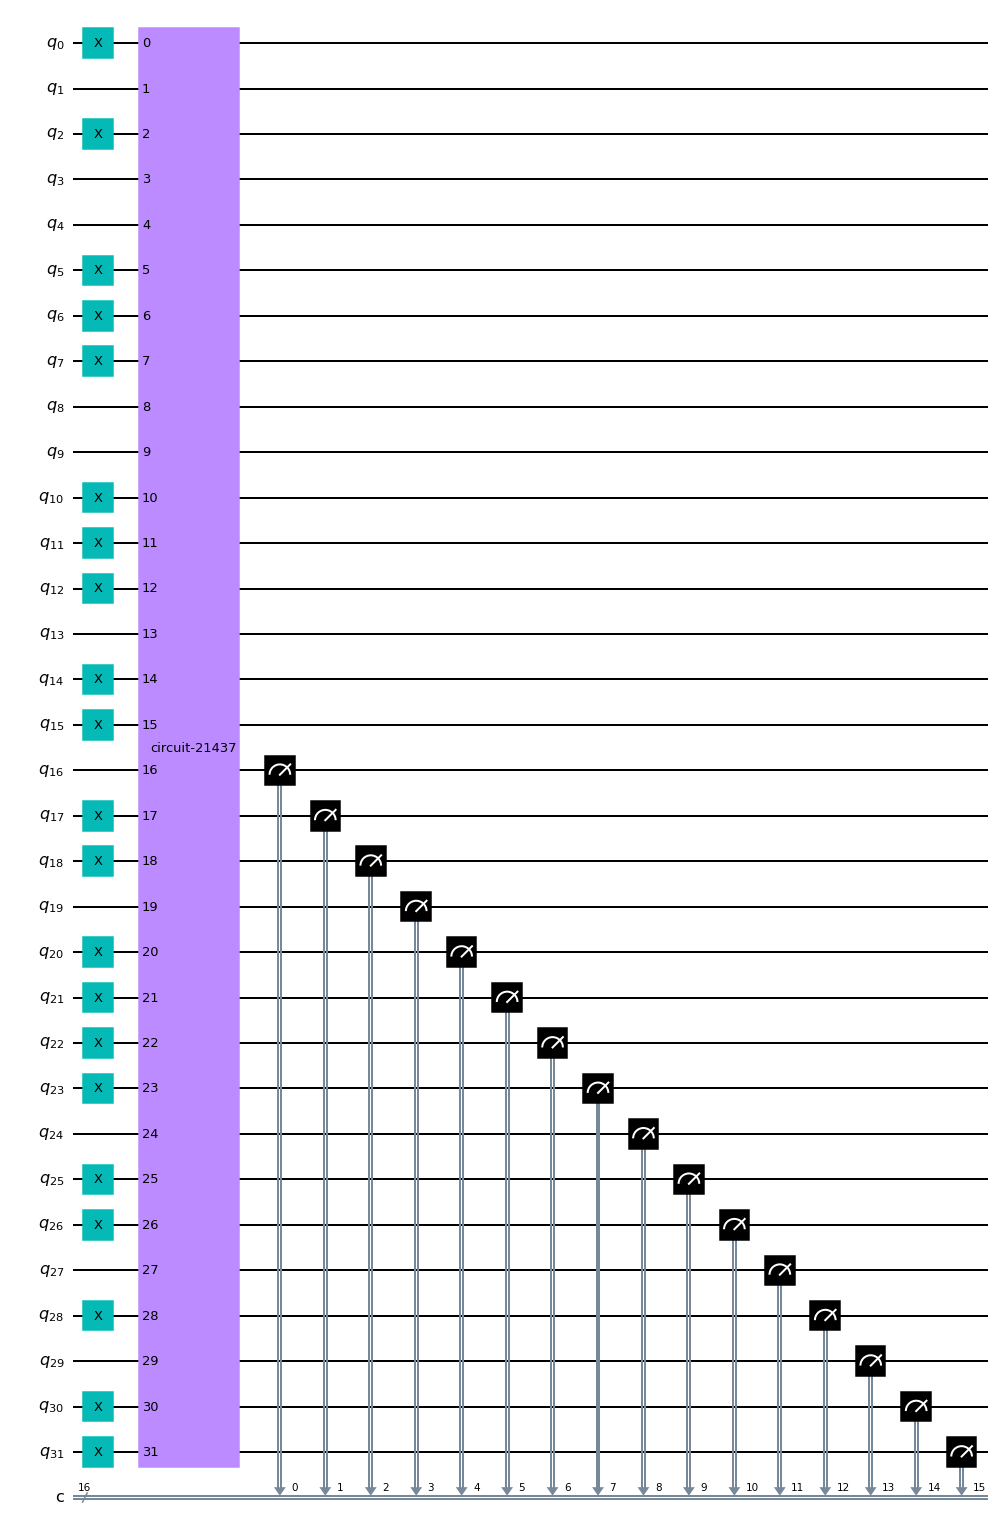

In [42]:
qc = QuantumCircuit(32, 16)

offset = 16
for index, i in enumerate(key):
    if i == '1':
        qc.x(index)
        
for index, i in enumerate(msg):
    if i == '1':
        qc.x(offset + index)

qc.append(saes, range(32))        
qc.measure(np.arange(16,32,1), range(16))
qc.draw('mpl')

In [227]:
# shots = 1
# simulator = Aer.get_backend('aer_simulator')
# res = execute(saes,backend=simulator, shots=shots).result()
# res

In [46]:
qcomp = provider.get_backend('simulator_mps')
verify_t_qc = transpile(qc, qcomp, optimization_level=2)

In [47]:
verify_t_qc.depth()

161

In [48]:
dict(verify_t_qc.count_ops())

{'cx': 368,
 'p': 224,
 'ccx': 96,
 'swap': 90,
 'x': 40,
 'u2': 28,
 'measure': 16,
 'h': 4}

In [242]:
job = execute(qc,backend=qcomp, shots = 1)
job_monitor(job)

Job Status: job has successfully run


In [243]:
result = job.result()
counts = result.get_counts()

In [244]:
list(counts.keys())[0][::-1]

'0000011100111000'

In [245]:
list(counts.keys())[0][::-1] == '0000011100111000'

True

###  Experiment 2: Get all states for superposition of all keys

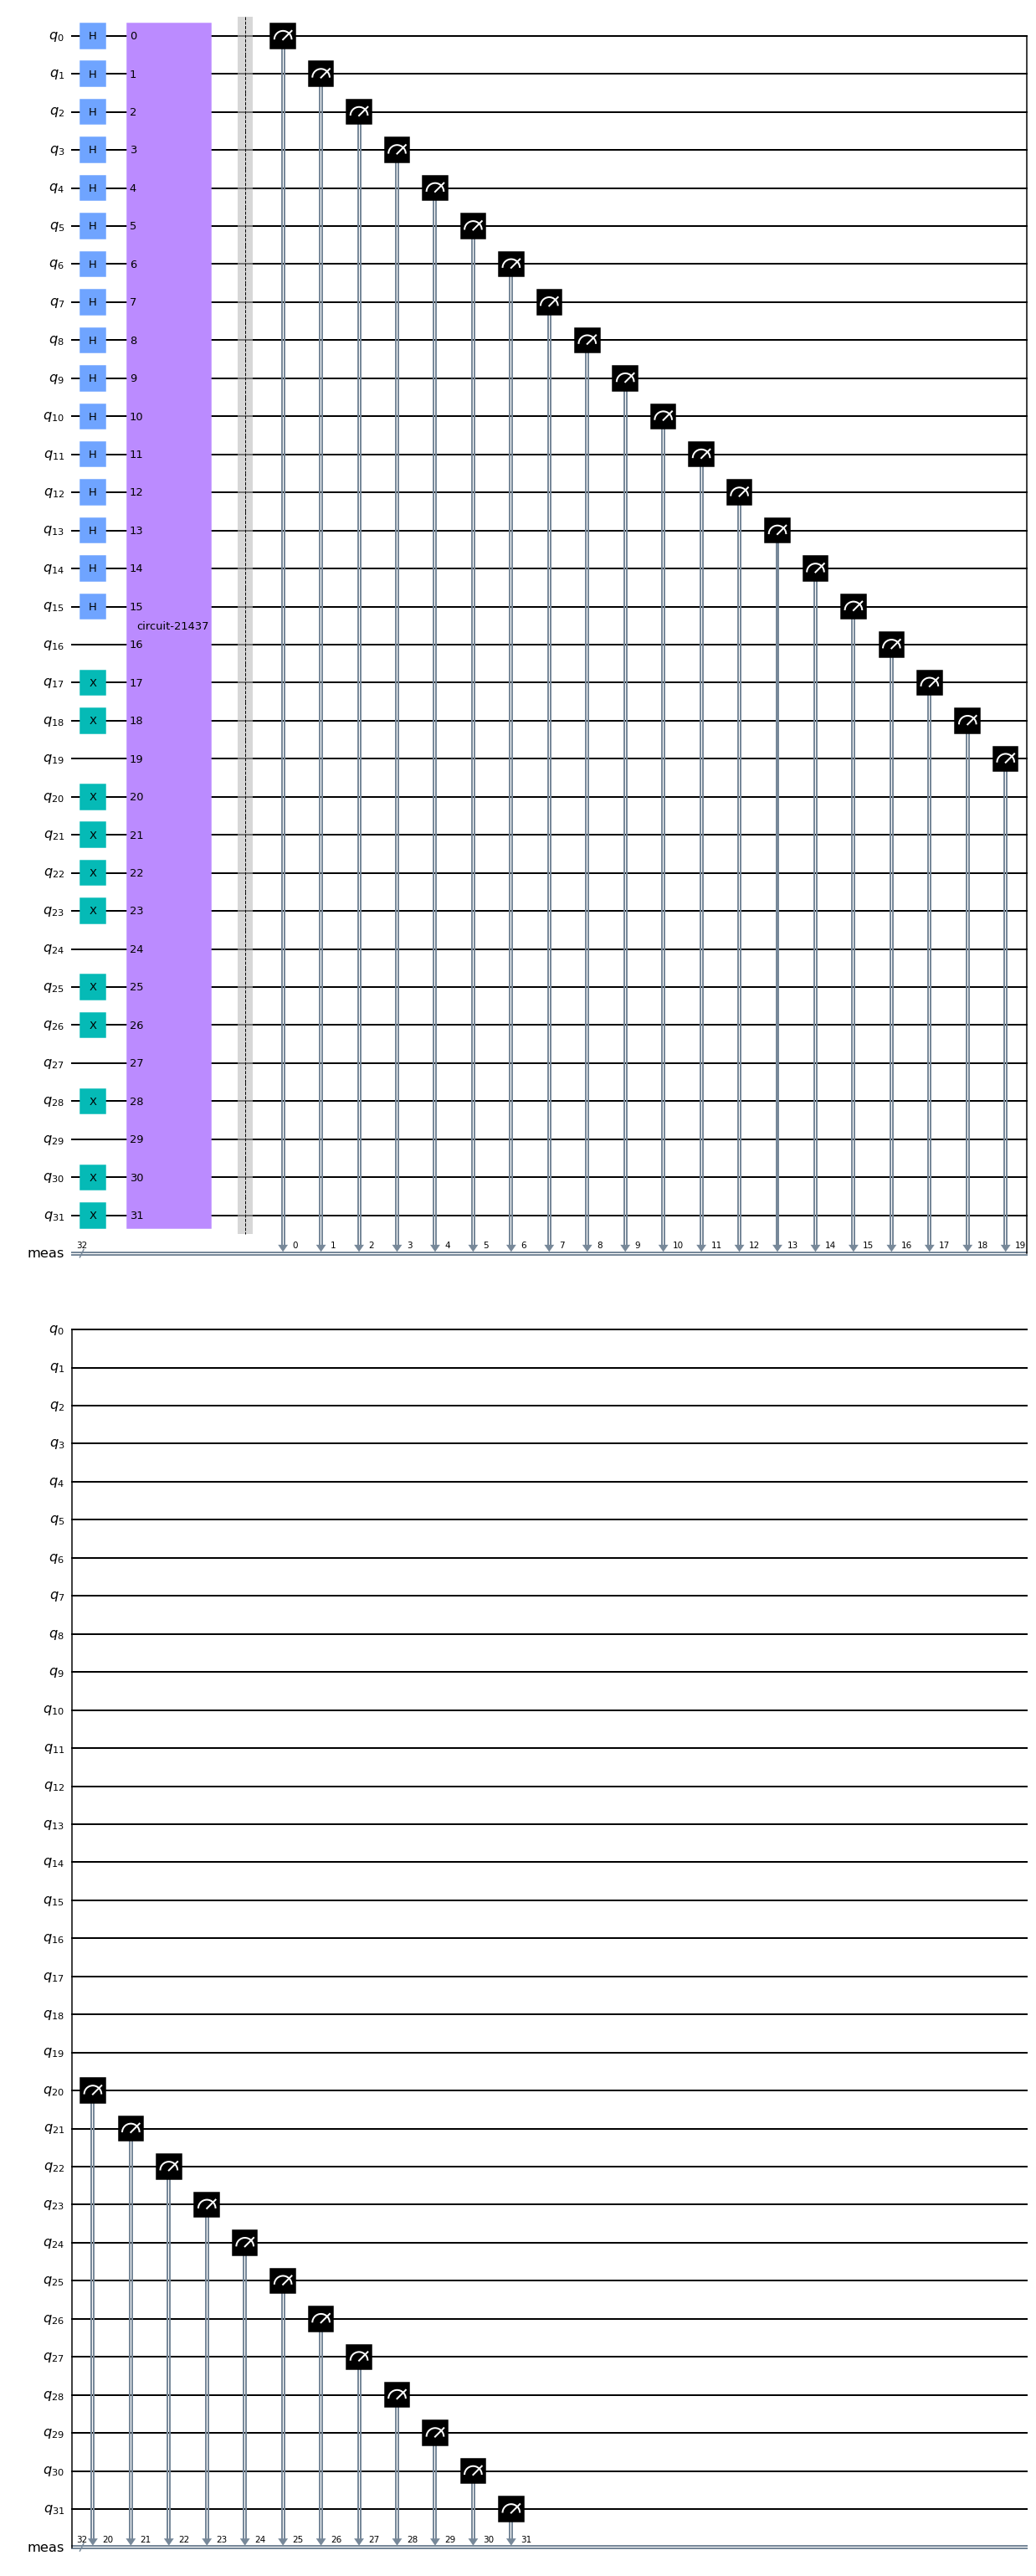

In [49]:
qc = QuantumCircuit(32)

# first 16 qubits for key
# later for plaintext

offset = 16
for i in range(16):
    qc.h(i)
        
for index, i in enumerate(msg):
    if i == '1':
        qc.x(offset + index)

qc.append(saes, range(32))
qc.measure_all()

qc.draw('mpl')

In [52]:
qcomp = provider.get_backend('simulator_mps')
super_t_qc = transpile(qc, qcomp, optimization_level=2)

In [53]:
super_t_qc.depth()

161

In [54]:
dict(super_t_qc.count_ops())

{'cx': 368,
 'p': 224,
 'ccx': 96,
 'swap': 90,
 'measure': 32,
 'x': 30,
 'u2': 28,
 'h': 20,
 'barrier': 1}

In [250]:
job = execute(t_qc,backend=qcomp, shots = 20000)
job_monitor(job)

Job Status: job incurred error     


In [ ]:
result = job.result()
counts = result.get_counts()

In [272]:
def hex_to_bin(s):
    return bin(int(s,16))[2:].zfill(16)[::-1]

with open('./results-saes21/expt2-basic/62553b1e192f3c40573be82c-output.json') as f:
    data = json.load(f)
    counts = list(data['results'][0]['data']['counts'].keys())
    i
    kc = { i[:16]: i[16:] for i in counts}
    print(kc.get(key))

None


In [273]:
len(counts)

3903

### Grover's Oracles

In [68]:
Uf1 = QuantumCircuit(33)

offset = 16

msg = '0110111101101011'
cipher = '0000011100111000'

for index, i in enumerate(msg):
    if i == '1':
        Uf1.x(offset + index)

Uf1 = Uf1.compose(saes_t_qc, range(32))

for index, i in enumerate(cipher):
    if i == '1':
        Uf1.x(offset + index)
        
for i in range(16):
    Uf1.x(offset + i)

qubits = list(np.arange(16,33,1))
Uf1.mct(qubits[:-1],qubits[-1])

for i in range(16):
    Uf1.x(offset + i)

for index, i in enumerate(cipher):
    if i == '1':
        Uf1.x(offset + index)

Uf1 = Uf1.compose(saes_inv_t_qc, range(32))
for index, i in enumerate(msg):
    if i == '1':
        Uf1.x(offset + index)

In [69]:
Uf1.draw()

»
 q_0: ──■───────────────────────────────────────────────────────────────────»
        │                                                                   »
 q_1: ──┼────────────────────────■──────────────────────────────────────────»
        │                        │                                          »
 q_2: ──┼────────────────────────┼────■─────────────────────────────────────»
        │                        │    │                                     »
 q_3: ──┼────■───────────────────┼────┼─────────────────────────────────────»
        │    │                   │    │                                     »
 q_4: ──┼────┼───────────────────┼────┼────■────────────────────────────────»
        │    │                   │    │    │                                »
 q_5: ──┼────┼───────────────────┼────┼────┼────■───────────────────────────»
        │    │                   │    │    │    │                           »
 q_6: ──┼────┼───────────────────┼────┼────┼────┼────■──────────────────────»
        │    │                   │    │    │    │    │                      »
 q_7: ──┼────┼───────────────────┼────┼────┼────┼────┼────■─────────────────»
        │    │                   │    │    │    │    │    │                 »
 q_8: ──┼────┼────■──────────────┼────┼────┼────┼────┼────┼─────────────────»
        │    │    │              │    │    │    │    │    │                 »
 q_9: ──┼────┼────┼──────────────┼────┼────┼────┼────┼────┼────■────────────»
        │    │    │              │    │    │    │    │    │    │            »
q_10: ──┼────┼────┼──────────────┼────┼────┼────┼────┼────┼────┼────■───────»
        │    │    │              │    │    │    │    │    │    │    │       »
q_11: ──┼────┼────┼────■─────────┼────┼────┼────┼────┼────┼────┼────┼───────»
        │    │    │    │         │    │    │    │    │    │    │    │       »
q_12: ──┼────┼────┼────┼─────────┼────┼────┼────┼────┼────┼────┼────┼────■──»
        │    │    │    │         │    │    │    │    │    │    │    │    │  »
q_13: ──┼────┼────┼────┼────■────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
        │    │    │    │    │    │    │    │    │    │    │    │    │    │  »
q_14: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
        │    │    │    │    │    │    │    │    │    │    │    │    │    │  »
q_15: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
      ┌─┴─┐  │    │    │    │    │    │    │    │    │    │    │    │    │  »
q_16: ┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
      ├───┤  │    │    │    │  ┌─┴─┐  │    │    │    │    │    │    │    │  »
q_17: ┤ X ├──┼────┼────┼────┼──┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼──»
      ├───┤  │    │    │    │  └───┘┌─┴─┐  │    │    │    │    │    │    │  »
q_18: ┤ X ├──┼────┼────┼────┼───────┤ X ├──┼────┼────┼────┼────┼────┼────┼──»
      └───┘┌─┴─┐  │    │    │       └───┘  │    │    │    │    │    │    │  »
q_19: ─────┤ X ├──┼────┼────┼──────────────┼────┼────┼────┼────┼────┼────┼──»
      ┌───┐└───┘  │    │    │            ┌─┴─┐  │    │    │    │    │    │  »
q_20: ┤ X ├───────┼────┼────┼────────────┤ X ├──┼────┼────┼────┼────┼────┼──»
      ├───┤       │    │    │            └───┘┌─┴─┐  │    │    │    │    │  »
q_21: ┤ X ├───────┼────┼────┼─────────────────┤ X ├──┼────┼────┼────┼────┼──»
      ├───┤       │    │    │                 └───┘┌─┴─┐  │    │    │    │  »
q_22: ┤ X ├───────┼────┼────┼──────────────────────┤ X ├──┼────┼────┼────┼──»
      ├───┤       │    │    │                      └───┘┌─┴─┐  │    │    │  »
q_23: ┤ X ├───────┼────┼────┼───────────────────────────┤ X ├──┼────┼────┼──»
      └───┘     ┌─┴─┐  │    │                           └───┘  │    │    │  »
q_24: ──────────┤ X ├──┼────┼──────────────────────────────────┼────┼────┼──»
      ┌───┐     └───┘  │    │                                ┌─┴─┐  │    │  »
q_25: ┤ X ├────────────┼────┼────────────────────────────────┤ X ├──┼────┼──»
      ├───┤         

In [70]:
# Uf1_gate = Uf1.to_gate()
# Uf1_gate.name = "UF1"

In [71]:
Uf2 = QuantumCircuit(34)

offset = 16

msg = '1100111100010011'
cipher = '1101000111101101'

for index, i in enumerate(msg):
    if i == '1':
        Uf2.x(offset + index)

Uf2 = Uf2.compose(saes_t_qc, range(32))

for index, i in enumerate(cipher):
    if i == '1':
        Uf2.x(offset + index)
        
for i in range(16):
    Uf2.x(offset + i)

qubits = list(np.arange(16,34,1))
Uf2.mct(qubits[:-1],qubits[-1])

for i in range(16):
    Uf2.x(offset + i)

for index, i in enumerate(cipher):
    if i == '1':
        Uf2.x(offset + index)

Uf2 = Uf2.compose(saes_inv_t_qc, range(32))
for index, i in enumerate(msg):
    if i == '1':
        Uf2.x(offset + index)

In [72]:
Uf2.draw()

»
 q_0: ──────────────────────────────────────────■───────────────────────────»
                                                │                           »
 q_1: ──────────────────────────────────────────┼────■──────────────────────»
                                                │    │                      »
 q_2: ───────■──────────────────────────────────┼────┼──────────────────────»
             │                                  │    │                      »
 q_3: ───────┼────■─────────────────────────────┼────┼──────────────────────»
             │    │                             │    │                      »
 q_4: ───────┼────┼─────────────────────────────┼────┼────■─────────────────»
             │    │                             │    │    │                 »
 q_5: ───────┼────┼─────────────────────────────┼────┼────┼────■────────────»
             │    │                             │    │    │    │            »
 q_6: ───────┼────┼─────────────────────────────┼────┼────┼────┼────■───────»
             │    │                             │    │    │    │    │       »
 q_7: ───────┼────┼─────────────────────────────┼────┼────┼────┼────┼────■──»
             │    │                             │    │    │    │    │    │  »
 q_8: ───────┼────┼────■───────────────────X────┼────┼────┼────┼────┼────┼──»
             │    │    │                   │    │    │    │    │    │    │  »
 q_9: ───────┼────┼────┼────■──────────────┼────┼────┼────┼────┼────┼────┼──»
             │    │    │    │              │    │    │    │    │    │    │  »
q_10: ───────┼────┼────┼────┼────■─────────┼────┼────┼────┼────┼────┼────┼──»
             │    │    │    │    │         │    │    │    │    │    │    │  »
q_11: ───────┼────┼────┼────┼────┼─────────┼────┼────┼────┼────┼────┼────┼──»
             │    │    │    │    │         │    │    │    │    │    │    │  »
q_12: ───────┼────┼────┼────┼────┼────■────X────┼────┼────┼────┼────┼────┼──»
             │    │    │    │    │    │         │    │    │    │    │    │  »
q_13: ───────┼────┼────┼────┼────┼────┼────■────┼────┼────┼────┼────┼────┼──»
             │    │    │    │    │    │    │    │    │    │    │    │    │  »
q_14: ───────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
             │    │    │    │    │    │    │    │    │    │    │    │    │  »
q_15: ───────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
      ┌───┐  │    │    │    │    │    │    │  ┌─┴─┐  │    │    │    │    │  »
q_16: ┤ X ├──┼────┼────┼────┼────┼────┼────┼──┤ X ├──┼────┼────┼────┼────┼──»
      ├───┤  │    │    │    │    │    │    │  └───┘┌─┴─┐  │    │    │    │  »
q_17: ┤ X ├──┼────┼────┼────┼────┼────┼────┼───────┤ X ├──┼────┼────┼────┼──»
      └───┘┌─┴─┐  │    │    │    │    │    │       └───┘  │    │    │    │  »
q_18: ─────┤ X ├──┼────┼────┼────┼────┼────┼──────────────┼────┼────┼────┼──»
           └───┘┌─┴─┐  │    │    │    │    │              │    │    │    │  »
q_19: ──────────┤ X ├──┼────┼────┼────┼────┼──────────────┼────┼────┼────┼──»
      ┌───┐     └───┘  │    │    │    │    │            ┌─┴─┐  │    │    │  »
q_20: ┤ X ├────────────┼────┼────┼────┼────┼────────────┤ X ├──┼────┼────┼──»
      ├───┤            │    │    │    │    │            └───┘┌─┴─┐  │    │  »
q_21: ┤ X ├────────────┼────┼────┼────┼────┼─────────────────┤ X ├──┼────┼──»
      ├───┤            │    │    │    │    │                 └───┘┌─┴─┐  │  »
q_22: ┤ X ├────────────┼────┼────┼────┼────┼──────────────────────┤ X ├──┼──»
      ├───┤            │    │    │    │    │                      └───┘┌─┴─┐»
q_23: ┤ X ├────────────┼────┼────┼────┼────┼───────────────────────────┤ X ├»
      └───┘          ┌─┴─┐  │    │    │    │                           └───┘»
q_24: ───────────────┤ X ├──┼────┼────┼────┼────────────────────────────────»
                     └───┘┌─┴─┐  │    │    │  ┌───┐                         »
q_25: ────────────────────┤ X ├──┼────┼────┼──┤ X ├─────────────────────────»
                    

In [73]:
# Uf2_gate = Uf2.decompose().to_gate()
# Uf2_gate.name = "UF2"

### Grover Circuit 1

In [83]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    
#     U_s = qc.to_gate()
#     U_s.name = "U$_s$"
    return qc

In [93]:
def grover_gate_cirq(num_iterations, U, inv):
    qc = QuantumCircuit(33)
    
    for i in range(num_iterations):
        if(i%10 == 0):
            print(i)
        qc.h(32)
        qc = qc.compose(U,range(33))
        qc = qc.compose(inv, range(16))
    
    return qc

In [94]:
qc = QuantumCircuit(33,16)

for i in range(16):
    qc.h(i)

qc.x(32)

inv_gate = diffuser(16)

t = 142
grover_gate = grover_gate_cirq(t, Uf1, inv_gate)
qc= qc.compose(grover_gate, range(33))
qc.measure(range(16), range(16))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [95]:
qc.draw()


KeyboardInterrupt



In [96]:
qcomp = provider.get_backend('simulator_mps')

In [97]:
# t_qc = transpile(qc, qcomp, optimization_level=2)

In [ ]:
job = execute(qc,backend=qcomp,shots = 1)
job_monitor(job)

In [ ]:
result = job.result()
counts = result.get_counts()

In [ ]:
counts

In [ ]:
len(counts)

### Grover Circuit 2

In [223]:
def grover_gate_cirq2(num_iterations, Uf1, Uf2, inv):
    qc = QuantumCircuit(34)
    
    for i in range(num_iterations):
        
        # Phase Inversion
        qc.h(33)
        qc.append(Uf1, range(33))
        qc.append(Uf2, range(34))
        qc.append(Uf1, range(33))

        # Inversion about mean
        qc.append(inv, range(16))
        
    return qc.to_gate()

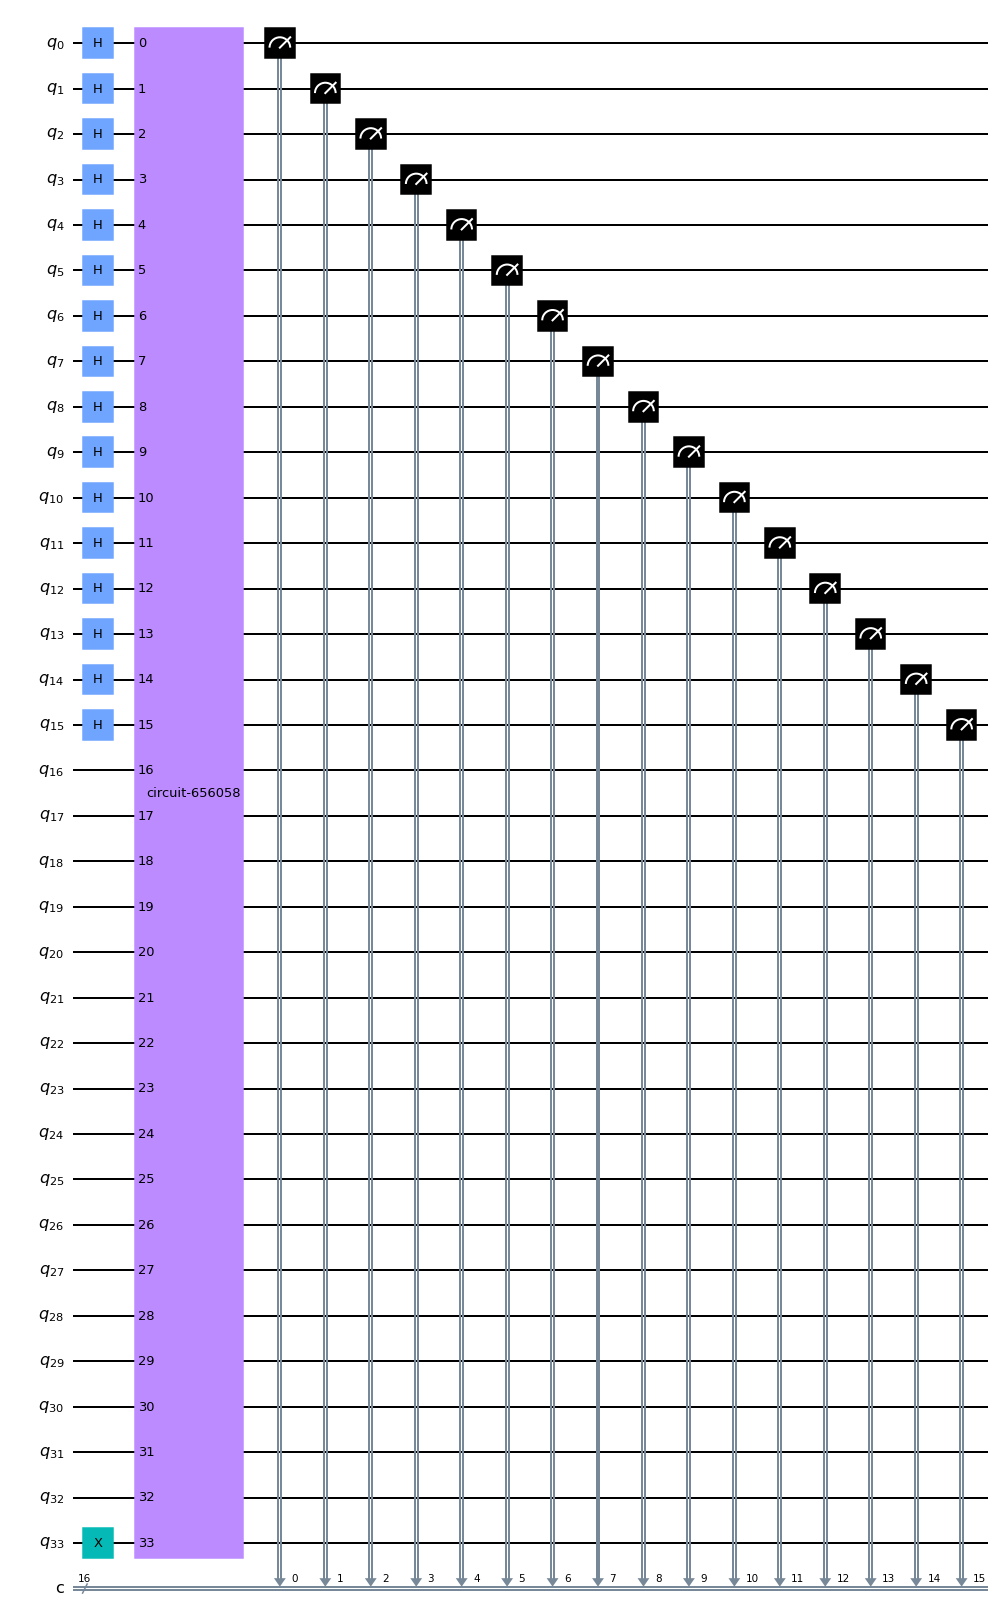

In [224]:
qc = QuantumCircuit(34,16)

for i in range(16):
    qc.h(i)

qc.x(33)

inv_gate = diffuser(16)

t = 142

grover_gate = grover_gate_cirq2(t, Uf1_gate, Uf2_gate, inv_gate)
qc.append(grover_gate, range(34))
qc.measure(range(16), range(16))

qc.draw('mpl')

In [ ]:
qcomp = provider.get_backend('ibmq_qasm_simulator')
t_qc = transpile(qc, qcomp, optimization_level=1)
job = execute(t_qc,backend=qcomp)
job_monitor(job)

In [ ]:
result = job.result()
counts = result.get_counts()

In [ ]:
counts

In [ ]:
len(counts)